In [1]:
import pickle
from pathlib import Path
import numpy as np
import gurobipy as gp; gp.Model()

from src.input import Input_uc, get_min_up_down_initials
from src.output import Output_uc
from src.unit_commitment import solve_uc 
from src.plot import plot_schedule_heatmap

Set parameter Username
Set parameter LicenseID to value 2659802
Academic license - for non-commercial use only - expires 2026-05-01


In [9]:
num_units = 122
num_periods = 24
reserve_margin = 0
time_start, time_end = np.datetime64("2022-07-02T00"), np.datetime64("2022-07-02T23")

In [10]:
path_folder_processed = Path.cwd() / "data" / "input" / "processed"

timestamp_2022 = np.load(path_folder_processed / "timestamp_2022.npy")
idx_time_start, idx_time_end = np.where(timestamp_2022 == time_start)[0][0], np.where(timestamp_2022 == time_end)[0][0]
idx_time_prev = idx_time_start - 1
if idx_time_prev < 0:
    raise NotImplementedError("not 2022-01-01T00 for the time start")

unit_type = np.load(path_folder_processed / "unit_type.npy")
idx_nuclear = np.load(path_folder_processed / "idx_nuclear.npy")
idx_coal = np.load(path_folder_processed / "idx_coal.npy")
idx_lng = np.load(path_folder_processed / "idx_lng.npy")
p_min = np.load(path_folder_processed / "p_min.npy")
p_max = np.load(path_folder_processed / "p_max.npy")
ramp_up = np.load(path_folder_processed / "ramp_up.npy")
ramp_down = np.load(path_folder_processed / "ramp_down.npy")
startup_ramp = np.load(path_folder_processed / "startup_ramp.npy")
shutdown_ramp = np.load(path_folder_processed / "shutdown_ramp.npy")
min_up = np.load(path_folder_processed / "min_up.npy")
min_down = np.load(path_folder_processed / "min_down.npy")
cost_lin = np.load(path_folder_processed / "cost_lin.npy")
cost_const = np.load(path_folder_processed / "cost_const.npy")

cost_startup_step_old = pickle.load(open(path_folder_processed / "cost_startup_step_old.pkl", "rb"))
num_cooling_steps_old = np.load(path_folder_processed / "num_cooling_steps_old.npy")
cost_startup_step = np.load(path_folder_processed / "cost_startup_step.npy")
step_length = np.load(path_folder_processed / "step_length.npy")

In [11]:
demand_2022 = np.load(path_folder_processed / "demand_2022.npy")
demand = demand_2022[idx_time_start:idx_time_end+1]

renewable_2022 = np.load(path_folder_processed / "renewable_2022.npy")
renewable = renewable_2022[idx_time_start:idx_time_end+1]

In [ ]:
# # KPG commitment decision data reliance (which i have 0 reason to do so)
# status_2022 = np.load(path_folder_processed / "status_2022.npy")
# u_prev = status_2022[:, idx_time_start-num_cooling_steps_old.max():idx_time_start]

# black start -96h (= 2 * 48 = 2 * max cooling length) hour
# guaranteed steady state for initial conditions
# at t=-1 (or -48h ~ -1h) (unless some inhumane numerical stability stuffs)
num_periods_prev = 60
u_prev = np.zeros((num_units, num_periods_prev), dtype=np.int64)
min_up_r, min_down_r, min_up_0, min_down_0 = get_min_up_down_initials(num_units, min_up, min_down, u_prev)
p_prev = np.zeros(num_units)

input_uc_prev = Input_uc(
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods_prev,
    # system
    demand=np.full((num_periods_prev), demand[0]),
    reserve=(np.full((num_periods_prev), demand[0]) - np.full((num_periods_prev), renewable[0])) * reserve_margin,
    renewable=np.full((num_periods_prev), renewable[0]),
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

output_uc_prev = Output_uc()
solve_uc(
    input_uc=input_uc_prev, output_uc=output_uc_prev, verbose=False, 
)

# return input_uc_prev, output_uc_prev
u_prev = output_uc_prev.u[:, -48:]
min_up_r, min_down_r, min_up_0, min_down_0 = get_min_up_down_initials(num_units, min_up, min_down, u_prev)
p_prev = output_uc_prev.p[:, -1]

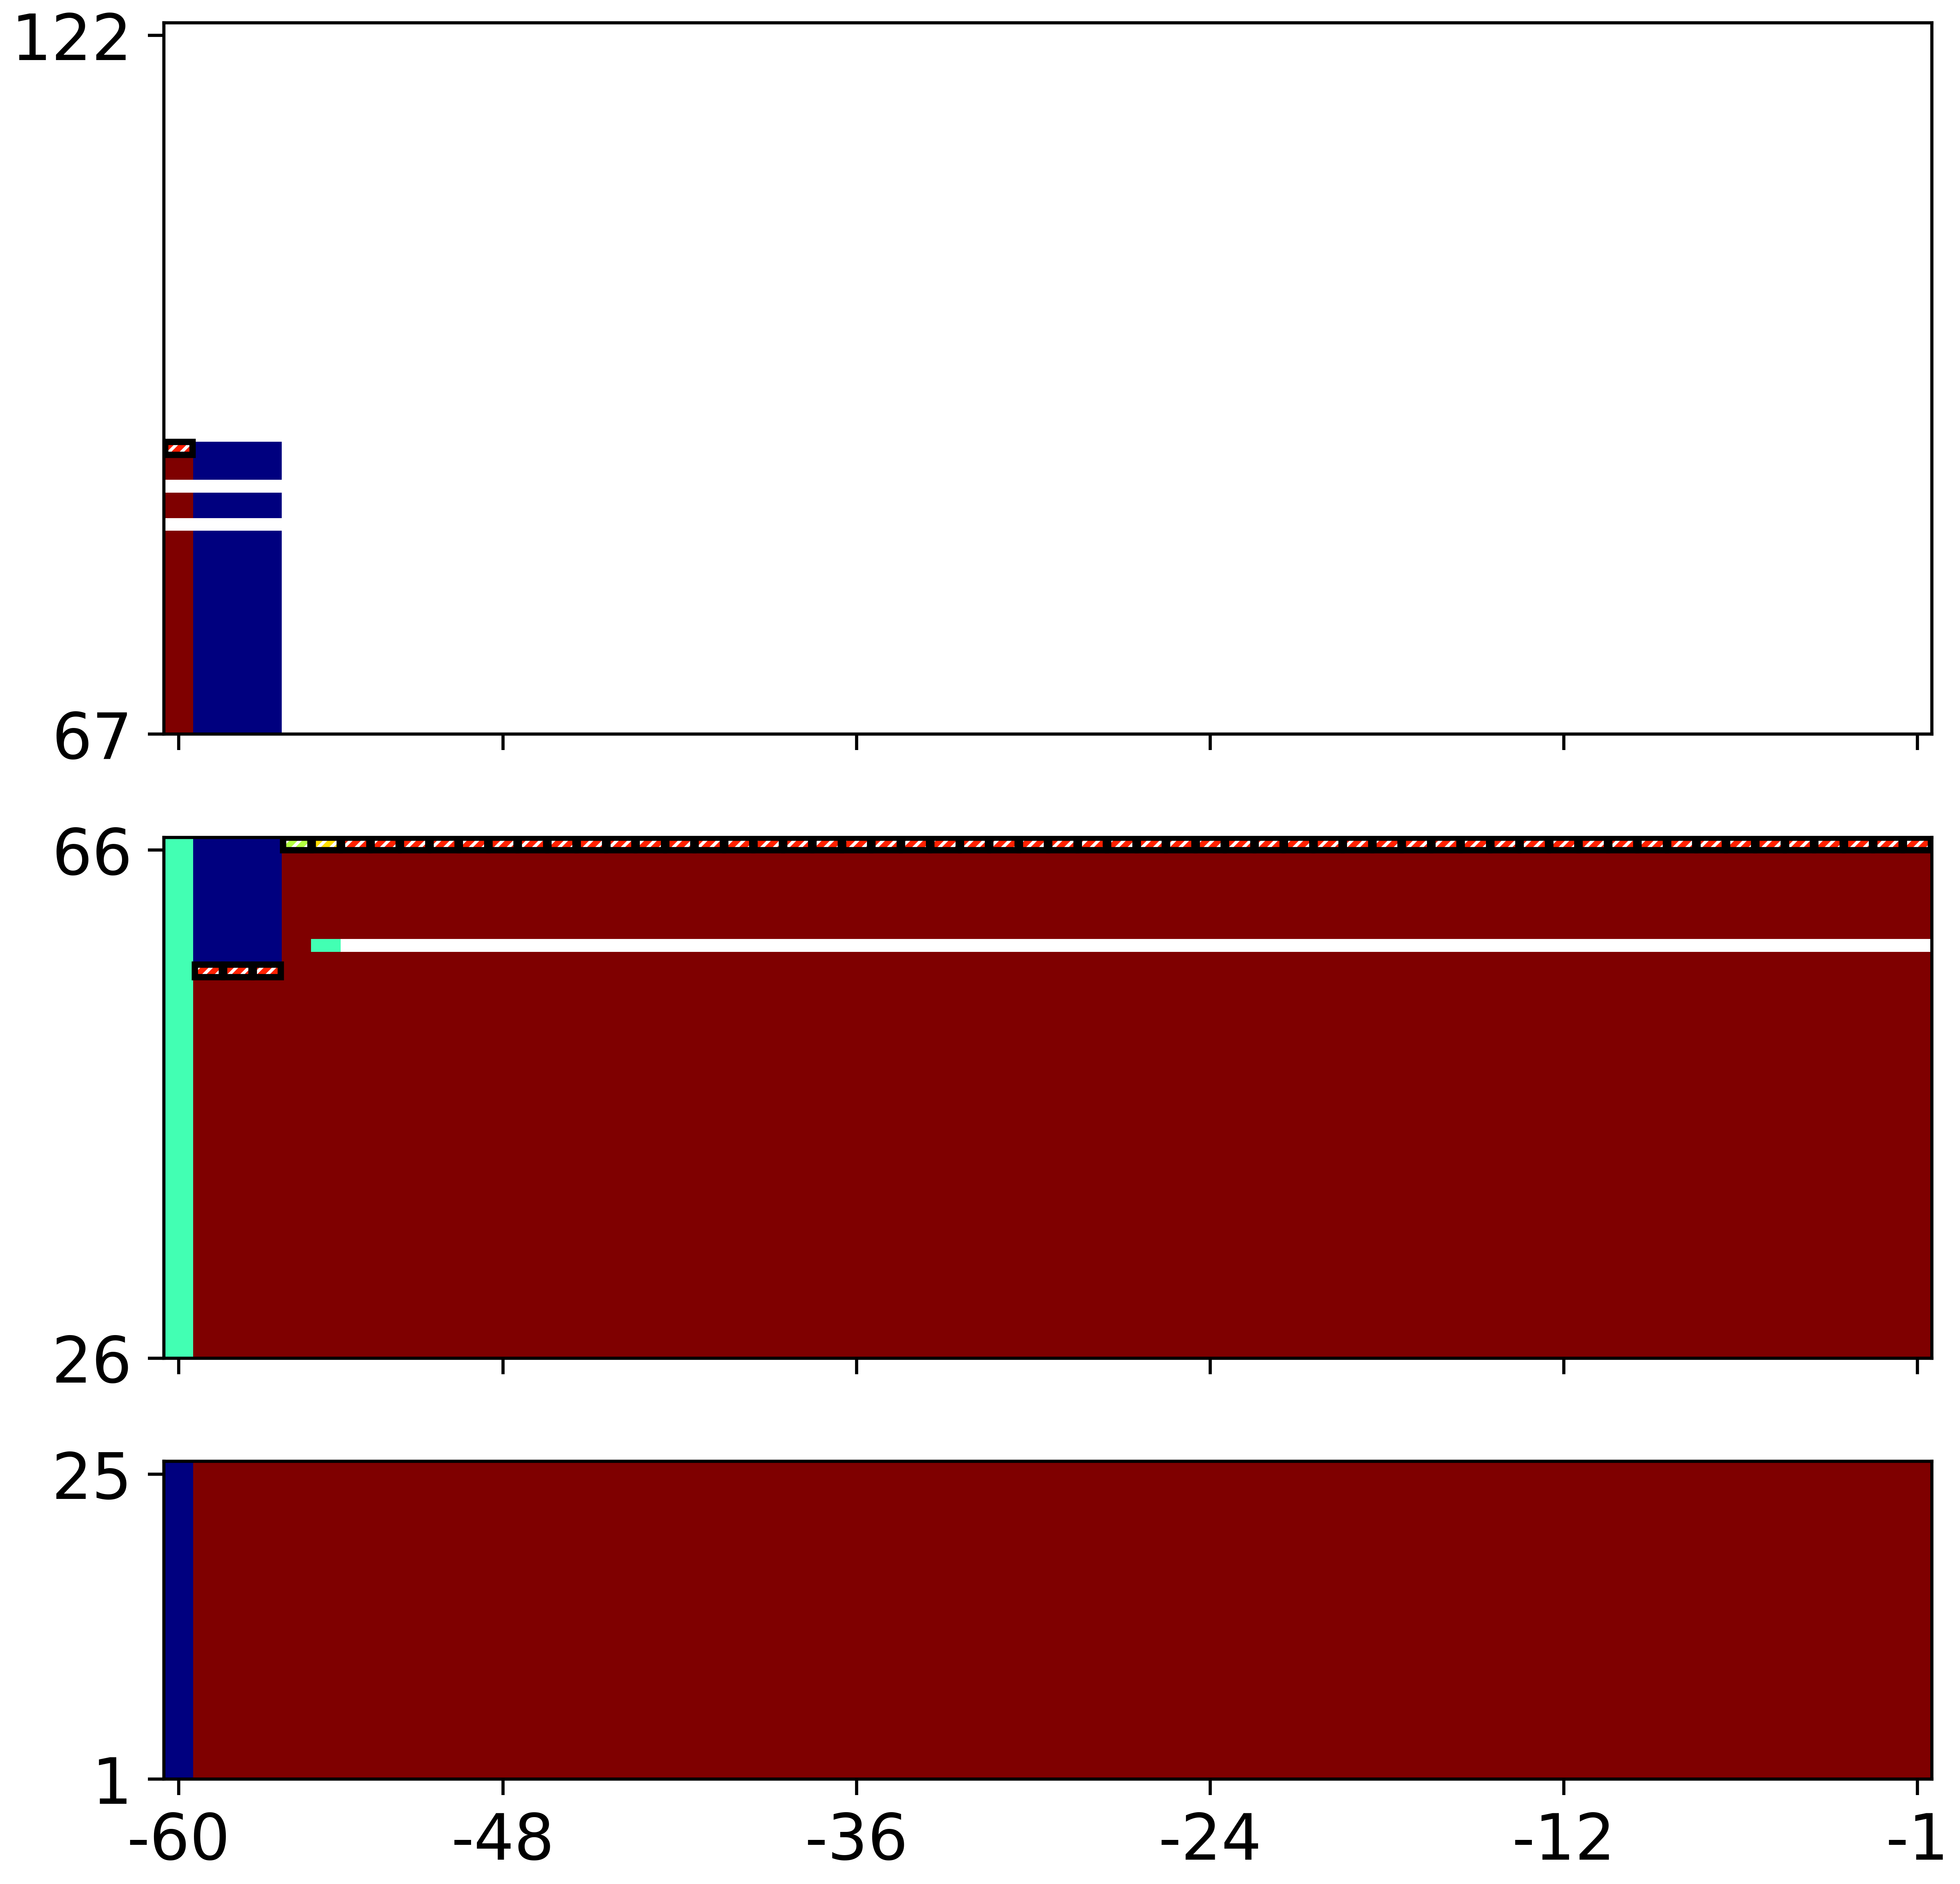

In [13]:
_ = plot_schedule_heatmap(input_uc=input_uc_prev, output_uc=output_uc_prev, is_prev=True, save_file_name=None)

---
---
---

In [14]:
input_uc = Input_uc(
    # meta
    unit_type=unit_type,
    idx_nuclear=idx_nuclear,
    idx_coal=idx_coal,
    idx_lng=idx_lng,
    num_units=num_units,
    num_periods=num_periods,
    # system
    demand=demand,
    reserve=(demand - renewable) * reserve_margin,
    renewable=renewable,
    # generator
    p_min=p_min,
    p_max=p_max,
    ramp_up=ramp_up,
    ramp_down=ramp_down,
    startup_ramp=startup_ramp,
    shutdown_ramp=shutdown_ramp,
    min_up=min_up,
    min_down=min_down,
    # cost function - generation
    cost_lin=cost_lin,
    cost_const=cost_const,
    # cost function - startup (paper formulation)
    cost_startup_step=cost_startup_step,
    step_length=step_length,
    # cost function - startup (lecture note formulation)
    cost_startup_step_old=cost_startup_step_old,
    num_cooling_steps_old=num_cooling_steps_old,
    # initial conditions
    p_prev=p_prev,
    u_prev=u_prev,
    min_up_r=min_up_r,
    min_down_r=min_down_r,
    min_up_0=min_up_0,
    min_down_0=min_down_0,
)

Set parameter OutputFlag to value 1
Set parameter Symmetry to value 2
Set parameter PreDual to value 2
Set parameter Presolve to value 1
Set parameter PreSparsify to value 2
Set parameter Disconnected to value 2
Set parameter Heuristics to value 1
Set parameter ProjImpliedCuts to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Arch Linux")

CPU model: 12th Gen Intel(R) Core(TM) i7-12700, instruction set [SSE2|AVX|AVX2]
Thread count: 20 physical cores, 20 logical processors, using up to 20 threads

Non-default parameters:
Disconnected  2
Heuristics  1
Symmetry  2
ProjImpliedCuts  2
PreDual  2
Presolve  1
PreSparsify  2

Optimize a model with 34678 rows, 23424 columns and 131656 nonzeros
Model fingerprint: 0x3be06cce
Variable types: 5856 continuous, 17568 integer (17568 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [3e+03, 6e+07]
  Bounds range     [1e+00, 7e+02]
  RHS range        [1e+00, 7e+04]
Presolve removed 23417 rows and 

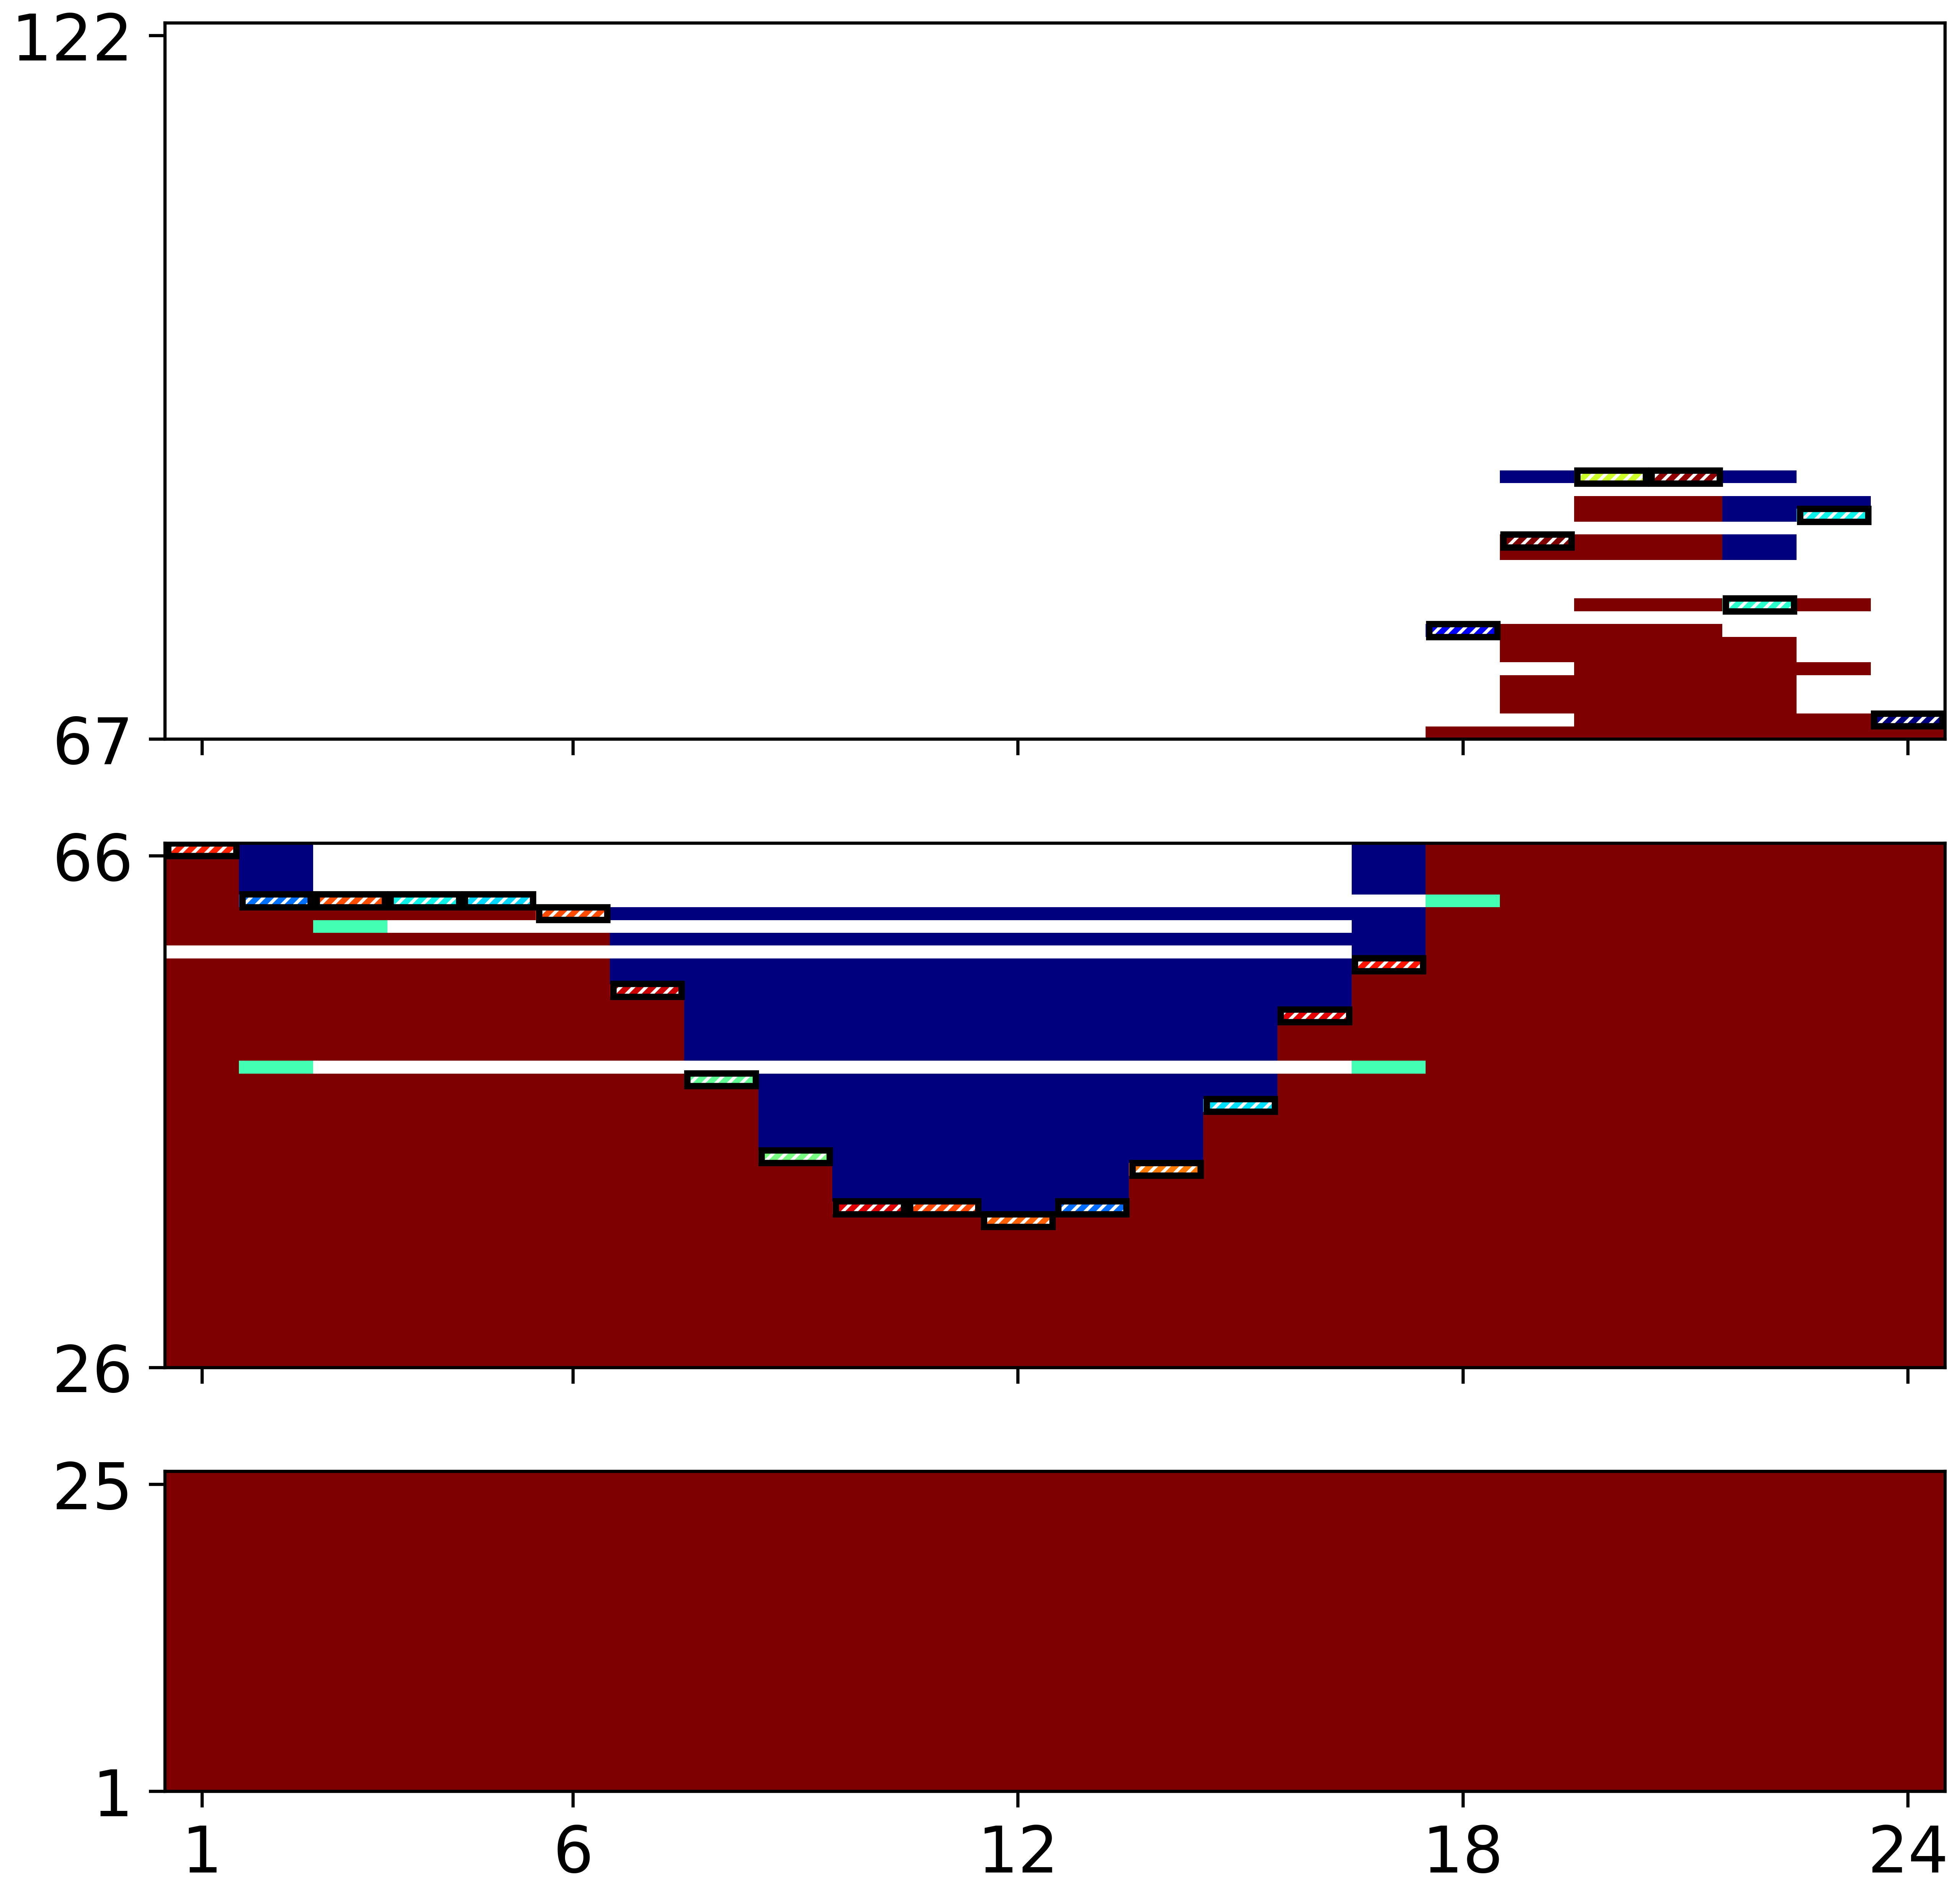

In [15]:
output_uc = Output_uc()
solve_uc(
    input_uc=input_uc, output_uc=output_uc, verbose=True, 
)

_ = plot_schedule_heatmap(input_uc=input_uc, output_uc=output_uc, save_file_name=None)